In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import math
import keras
from keras.models import model_from_yaml
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from sklearn.externals.joblib import dump, load
import tensorflow as tf
import os
from sklearn import preprocessing
from datetime import datetime
import time
import re


In [82]:
def smapetf(yTrue, yPred):
    ratio = tf.abs(yTrue - yPred) / (tf.abs(yTrue) + tf.abs(yPred))
    return tf.reduce_mean(200/48 * tf.reduce_sum(ratio, axis = 1) )

def smape(yTrue, yPred):
    ratio = np.abs(yPred - yTrue) / (np.abs(yTrue) + np.abs(yPred))
    return  np.mean( (200/yTrue.shape[1] ) * np.sum( ratio, axis = 1))

In [83]:
def naive(time_series):
    predictions = np.empty(shape = [0,48])
    
    for ts in time_series:
        ts = ts[~np.isnan(ts)]
        naive_prediction = np.full((1, 48), ts[-1:])
        predictions = np.vstack((predictions, naive_prediction))
    return predictions


In [93]:
from sklearn.metrics import mean_absolute_error

train_file_path = "Dataset/Train/Hourly-train.csv"
test_file_path = "Dataset/Test/Hourly-test.csv"

# Read Train data
train = pd.read_csv(train_file_path)
del train['V1']

yPred = naive(train.values)

# Read test data
test = pd.read_csv(test_file_path)
del test['V1']

yTrue = test.values

# calculate sampe
#print(smape2(yTrue, yPred))
#print(smape3(yTrue, yPred))
#print(mean_absolute_error(yTrue, yPred))
print(smape(yTrue, yPred))
print(smapetf(yTrue, yPred))

40.98788924187885
tf.Tensor(40.987889241878854, shape=(), dtype=float64)


In [94]:
from tensorflow.python.keras.utils import Sequence
import numpy as np   

class Mygenerator(Sequence):

    def __init__(self, raw_ts, in_ts_len, out_ts_len, batch_size):
        self.x, self.y = self.__create_training_data(raw_ts, in_ts_len, out_ts_len)
        self.batch_size = batch_size
    
    def __create_training_data(self, raw_ts, in_ts_len, out_ts_len):
        
        data_x =  np.empty(shape=[0, in_ts_len], dtype = np.float64)
        data_y =  np.empty(shape=[0, out_ts_len], dtype = np.float64)
        #raw_ts = preprocessing.minmax_scale(raw_ts)

        i = 0
        
        while True:
            start_x_indx = i*in_ts_len
            end_x_indx = (i+1)*in_ts_len
            end_y_indx = end_x_indx + out_ts_len
            
            if end_y_indx > raw_ts.shape[1]:  break
                
            data_x = np.vstack((data_x, raw_ts[:, start_x_indx : end_x_indx ]))
            data_y = np.vstack((data_y, raw_ts[:, end_x_indx : end_y_indx]))
            
            i+=1

        data_x = data_x[~np.isnan(data_y).any(axis=1)]
        data_y = data_y[~np.isnan(data_y).any(axis=1)]
        
        x = np.arange(0,data_x.shape[1])
        
        return data_x, data_y
            

    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size, :]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size, :]
        

        return np.array(batch_x)[:,:,np.newaxis], np.array(batch_y)[:,:]

    def get_data(self):
        return self.x, self.y

In [126]:
EPOCHS = 100
BS = 50
in_ts_len = 48
out_ts_len = 48

gen = Mygenerator(train.values, in_ts_len, out_ts_len, BS)

print(gen.__len__())
model = Sequential()


model.add(LSTM(200, batch_input_shape=(BS, in_ts_len, 1),  activation='tanh',
              kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))

model.add(Dense(48, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3)))

opt = keras.optimizers.RMSprop(lr=0.01)#,  clipvalue=0.5)

#model.compile(loss='mean_squared_error', optimizer=opt)
model.compile(loss=smapetf, optimizer=opt)
#model.compile(loss=smape, optimizer=opt)

137


In [127]:
hist = model.fit_generator(gen, steps_per_epoch= gen.__len__(), epochs=EPOCHS)

Epoch 1/100
137/137 [==============================] - 11s 83ms/step - loss: 95.8297
Epoch 2/100
137/137 [==============================] - 11s 81ms/step - loss: 80.4703
Epoch 3/100
137/137 [==============================] - 11s 80ms/step - loss: 75.0227
Epoch 4/100
137/137 [==============================] - 11s 80ms/step - loss: 70.4192
Epoch 5/100
137/137 [==============================] - 11s 79ms/step - loss: 66.6967
Epoch 6/100
137/137 [==============================] - 11s 79ms/step - loss: 63.9459
Epoch 7/100
137/137 [==============================] - 11s 79ms/step - loss: 63.1138
Epoch 8/100
137/137 [==============================] - 11s 80ms/step - loss: 61.2878
Epoch 9/100
137/137 [==============================] - 11s 81ms/step - loss: 60.4346
Epoch 10/100
137/137 [==============================] - 11s 82ms/step - loss: 59.7570
Epoch 11/100
137/137 [==============================] - 11s 79ms/step - loss: 58.9404
Epoch 12/100
137/137 [==============================] - 11s 80m

137/137 [==============================] - 12s 85ms/step - loss: 40.6572
Epoch 97/100
137/137 [==============================] - 13s 98ms/step - loss: 40.8616
Epoch 98/100
137/137 [==============================] - 12s 85ms/step - loss: 40.4810
Epoch 99/100
137/137 [==============================] - 11s 83ms/step - loss: 40.4812
Epoch 100/100
137/137 [==============================] - 11s 81ms/step - loss: 40.6390


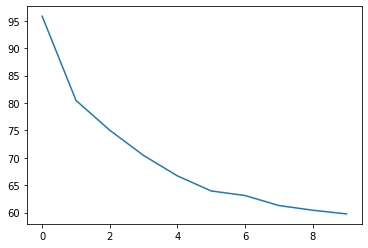

In [128]:
#print(lhist.history['loss'])

x = np.arange(0,10) 
y = np.array(hist.history['loss'])
#y = preprocessing.minmax_scale(y, axis=0)
plt.plot(x,y[:10])

In [144]:
def predict(model, time_series):
    weights = model.get_weights()
    single_item_model = Sequential()
    single_item_model.add(LSTM(200, batch_input_shape=(1, 48, 1),  activation='tanh',
              kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
    single_item_model.add(Dense(48, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3)))
    
    single_item_model.set_weights(weights)
    
    opt = keras.optimizers.RMSprop(lr=0.01)
    single_item_model.compile(loss=smapetf, optimizer=opt)
    
    predictions = np.empty(shape = [0,48])
    
    for ts in time_series:
        ts = ts[~np.isnan(ts)]
        ts = ts[-48:].reshape(1,48,1)
        prediction = single_item_model.predict(ts, batch_size = 1)
        print(prediction)
        predictions = np.vstack((predictions, naive_prediction))
        
    return predictions

In [145]:
train_file_path = "Dataset/Train/Hourly-train.csv"
test_file_path = "Dataset/Test/Hourly-test.csv"

# Read Train data
train = pd.read_csv(train_file_path)
del train['V1']

yPred = predict(model,train.values)

# Read test data
test = pd.read_csv(test_file_path)
del test['V1']

yTrue = test.values

print(smape(yTrue, yPred))


[[873.2452   804.68646  753.88715  719.9916   690.9486   709.18066
  711.9126    -6.289099 623.0405   606.43243  609.8916   617.5731
  627.3968   650.4597   693.8174   736.46735  768.5776   810.44464
  847.1874   871.5719   899.244    910.6671   911.36505  899.8011
  852.0086   797.8471   752.9105   723.8159   708.4132   712.46533
  707.1996   675.1053   629.5524   609.50397  609.54224  617.7012
  628.27716  650.4542   696.8525   737.79095  777.50696  812.4031
  842.3395   864.4228   877.96484  885.22455  880.0054   866.4215  ]]
[[1431.1898    1311.994     1230.6063    1178.1538    1137.1957
  1202.1697    1312.3121      -7.1280484 1315.8765    1279.2095
  1298.4027    1329.2733    1355.7905    1391.21      1456.9039
  1523.9574    1570.673     1624.7601    1638.7244    1605.5432
  1638.3074    1629.8915    1610.7129    1550.7723    1423.1443
  1316.92      1244.7731    1196.1465    1167.6975    1206.611
  1296.5837    1326.5602    1307.5916    1273.0038    1286.3774
  1314.6421    135

[[420.47876  384.67258  358.11734  336.39944  321.10535  319.37195
  301.4851    -8.791953 237.83995  232.51877  233.81468  235.47386
  241.03217  254.67148  280.93774  308.3387   333.30896  358.32898
  388.40912  420.07504  419.4793   426.74332  427.09418  421.43915
  402.80072  375.8801   350.91385  335.42743  326.01227  320.89664
  299.07788  262.44003  237.60231  231.18788  230.96523  235.85793
  243.68776  254.69786  283.81476  311.77563  336.82825  360.90833
  382.3359   398.5306   409.44992  414.43747  410.84195  402.81125 ]]
[[1431.3356   1312.07     1230.6797   1178.2152   1137.3285   1202.4537
  1313.0562     -7.112706 1318.0078   1281.025    1299.9286   1330.7916
  1357.4669   1392.9819   1458.6768   1526.0367   1572.9708   1627.1984
  1640.4025   1606.5563   1638.9003   1630.3417   1611.0216   1550.9583
  1423.2811   1316.9927   1244.8088   1196.213    1167.8198   1206.8672
  1297.2761   1327.8789   1309.4238   1274.6343   1287.9065   1316.1426
  1351.7227   1386.1655   145

[[1429.8677    1311.5188    1230.1863    1177.8572    1136.1533
  1199.4442    1304.5884      -7.3169527 1293.2678    1260.01
  1282.3595    1313.298     1338.0873    1372.4304    1438.0914
  1501.7744    1546.1062    1598.7004    1620.7874    1594.8842
  1632.0729    1625.1729    1607.5205    1548.926     1421.858
  1316.4304    1244.7241    1195.7938    1166.7863    1204.1992
  1289.4338    1312.6918    1288.207     1255.8212    1270.3082
  1298.8698    1332.3119    1366.2865    1433.1307    1494.9783
  1550.6246    1592.2904    1607.6873    1598.48      1592.5596
  1586.288     1555.1962    1507.4703   ]]
[[1209.7438   1107.6992   1036.3196    989.2411    952.36444  1003.8272
  1085.114      -7.633815 1065.219    1037.6987   1053.1251   1078.4052
  1100.505    1131.1184   1187.9448   1241.2854   1280.5846   1328.7052
  1354.2112   1336.9099   1370.1688   1369.1064   1353.5206   1306.2263
  1200.2546   1109.345    1046.2528   1002.6736    978.5139   1008.64374
  1072.0271   1082.8405

[[ 26.847761  18.528622  18.732973  18.514894  23.666945  62.033497
  181.68333  -11.092684 478.05508  431.7244   396.31992  419.21307
  465.86075  475.51077  472.6432   523.37494  546.97833  561.71735
  425.0413   245.56299  167.91075  128.59756   85.04823   51.124813
   27.824     22.113169  18.593904  22.246796  26.321598  54.093864
  164.98639  303.7624   421.67065  390.4668   379.07526  410.46347
  451.28256  456.34344  461.04953  505.90463  535.0704   532.7765
  404.30725  256.6592   174.22473  134.97687   98.508606  62.05081 ]]
[[ 16.77854   12.473264  13.325698  14.276467  18.96675   45.386395
  131.65451  -11.21307  350.3543   310.8465   279.5599   294.47562
  328.31802  333.96597  330.15787  369.85953  388.80875  401.5004
  290.6552   157.94182   99.52365   73.320984  47.011063  26.984568
   15.492528  13.788698  13.68636   16.284393  18.656565  40.99879
  120.938675 225.41536  308.30905  282.52914  269.80298  290.0052
  318.44965  321.62634  323.65976  359.16376  385.21146  

[[18.554026 17.665361 17.469418 17.510633 17.17335  17.011644 17.195665
  -8.897235 19.197098 20.70282  21.947454 22.440512 23.09035  23.863398
  24.104357 24.234718 23.555183 23.273441 23.775867 22.997908 21.518755
  21.019396 19.863737 19.220303 18.50797  17.788103 17.529345 17.251965
  17.245893 16.943432 17.211924 17.93588  19.381329 20.72158  21.99231
  22.648067 23.322605 23.75231  24.606892 24.70041  23.73081  24.585443
  23.815865 23.100964 21.594967 20.513643 19.54387  19.258196]]
[[18.15949  17.233173 16.898277 16.813425 16.354174 16.184422 16.370535
  -8.864731 18.905336 20.627596 22.059855 22.779243 23.668093 24.567663
  24.933199 25.113585 24.43834  24.13478  24.604065 23.597328 21.767744
  21.030481 19.674704 18.918196 18.030767 17.317865 16.978315 16.563757
  16.497414 16.190607 16.446785 17.375467 19.16798  20.715622 22.200882
  23.029116 23.89821  24.488892 25.426846 25.557978 24.664646 25.481815
  24.709787 23.782576 21.879606 20.514013 19.391052 18.976223]]
[[19.2084

[[17.566084 16.67608  16.511852 16.56236  16.321228 16.254833 16.540623
  -9.101085 18.603592 19.97827  21.16142  21.720915 22.322477 23.051058
  23.289038 23.365623 22.650501 22.25975  22.661774 21.78889  20.47353
  20.048443 18.86991  18.195011 17.465153 16.782776 16.549013 16.319092
  16.420965 16.25032  16.602741 17.35189  18.810514 20.029486 21.245876
  21.960941 22.605667 22.977688 23.777473 23.774593 22.868637 23.592299
  22.738691 21.99719  20.57414  19.516226 18.539688 18.258778]]
[[18.499237 17.578974 17.45717  17.58991  17.4357   17.300507 17.652645
  -8.975013 19.66428  21.106941 22.294136 22.722752 23.183584 23.888395
  24.028118 24.083162 23.346916 22.975067 23.417944 22.613003 21.280811
  20.846827 19.741388 19.097776 18.458359 17.742674 17.529404 17.376528
  17.50587  17.268835 17.696327 18.484936 19.868782 21.11464  22.298538
  22.878937 23.42085  23.71157  24.493279 24.507267 23.46806  24.286867
  23.43952  22.769495 21.345201 20.336523 19.382004 19.114813]]
[[18.7842

[[18.408089 17.485989 17.106302 16.964785 16.389174 16.19028  16.316854
  -8.873762 18.92057  20.766138 22.26822  23.061825 24.074766 25.027456
  25.448965 25.674776 25.017155 24.750113 25.218637 24.173923 22.243689
  21.409624 20.022295 19.229095 18.274315 17.56224  17.191387 16.68551
  16.53069  16.170761 16.380238 17.325384 19.195465 20.868889 22.427738
  23.329824 24.28377  24.956442 25.94345  26.116207 25.253683 26.081991
  25.346193 24.345749 22.331602 20.885572 19.716951 19.285929]]
[[18.135777 17.25864  16.970968 16.880863 16.360622 16.217562 16.196217
  -8.869132 17.964853 19.305672 20.489056 21.032818 21.872858 22.688013
  23.081022 23.311268 22.744291 22.582043 23.217617 22.524706 21.102892
  20.668018 19.45766  18.8497   18.037273 17.290724 16.961374 16.529402
  16.414066 16.109997 16.1665   16.696186 18.09595  19.34305  20.614983
  21.350399 22.16177  22.724466 23.667374 23.844637 23.053457 23.923578
  23.27704  22.630146 21.20608  20.148859 19.211079 18.925724]]
[[15.8727

[[22.113155 18.203054 16.671886 16.491617 17.305147 18.365458 21.72553
  -9.472108 34.84807  38.898792 44.465794 49.8558   53.637035 57.96717
  62.509605 67.763176 69.61255  67.82866  62.35572  54.541256 47.371487
  41.720314 35.061703 28.821018 22.264374 18.66887  16.806904 17.161655
  17.27798  17.390278 20.924828 26.323675 32.464252 37.22498  44.38252
  50.414528 55.712013 59.189705 64.176544 68.40882  68.66699  68.64337
  62.245987 54.228832 47.663353 41.18067  33.779808 28.28443 ]]
[[ 40.57054    27.811308   22.11504    21.114405   22.427977   29.656904
   46.243786  -10.9971285 102.319214  105.00903   112.620514  127.30287
  138.5493    145.64366   150.93149   166.05934   174.6843    173.99324
  147.23784   112.6241     92.758385   85.20461    70.51167    54.030315
   38.987446   27.24015    22.08398    20.95986    21.631123   28.643564
   45.4831     72.92321    95.075615   98.73242   107.26257   121.807274
  134.01883   140.0073    147.42123   164.51166   173.87193   174.57286


[[ 72.85342   43.34642   33.321182  28.849163  34.76326   63.578915
  163.2293   -10.893683 464.50647  433.8412   431.70557  477.68042
  537.4957   553.1768   556.10187  613.1344   642.3041   661.6173
  531.64465  362.184    275.77646  233.41153  176.02744  120.6092
   72.36692   45.742485  31.98833   31.280066  36.231636  57.80146
  152.24362  283.96725  416.87683  396.4246   412.60345  463.88812
  522.81335  534.26917  545.2344   597.30194  632.52014  637.1547
  507.46143  356.35376  267.57123  222.23996  170.04677  118.38495 ]]
[[ 33.06707   23.064604  20.397968  21.93299   26.491037  48.968693
  111.746994 -10.869367 269.17172  246.04929  231.0834   247.99838
  274.3382   281.38272  280.9997   314.10336  334.48663  340.68515
  252.05214  151.01637  109.748795  88.58257   67.10228   47.100063
   31.604078  23.498444  21.56503   22.662477  26.00818   47.1527
  104.02775  183.62639  241.97162  227.94447  222.94359  243.39696
  264.94745  270.04968  276.10568  309.5221   333.40225  331

In [151]:
x, y = gen.get_data()
x = x[:BS,:].reshape(BS, -1, 1)

prediction = model.predict(np.array(x), batch_size=BS)
#print(prediction.shape)
#prediction = prediction.reshape(BS,-1,3)
#prediction = prediction[:,0]
print(prediction[0,:])

#time = np.arange(0, prediction.shape[1])

#plt.plot(time, prediction[2,:])


[870.81995   802.61      751.87885   718.0886    689.0428    706.49774
 708.22614    -6.2919044 618.406     602.0739    605.2477    612.8251
 622.46814   645.429     688.77344   731.4781    763.5357    805.5409
 842.51807   866.54535   895.4268    906.82904   907.80817   896.557
 849.3166    795.4467    750.5721    721.56055   706.2729    709.8667
 703.62244   671.035     625.23975   605.16833   605.08606   613.10376
 623.38513   645.62274   691.8363    732.9141    772.56165   807.48114
 837.8049    860.256     874.0892    881.4058    876.4028    863.0611   ]


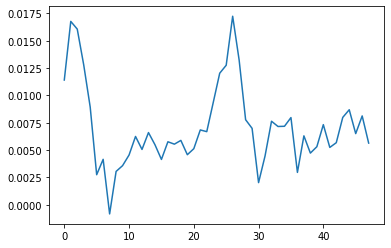

In [180]:
plt.plot(x,prediction[3,:])

In [164]:
data_all = np.array(np.random.random_integers(0, 10, (200, 48)), dtype=np.float32)
data_all = data_all.reshape(200,48,1)
y = model.predict(data_all)


/Users/d070867/miniconda3/envs/pjawt/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  """Entry point for launching an IPython kernel.


InvalidArgumentError:  Specified a list with shape [50,1] from a tensor with shape [32,1]
	 [[node lstm_36/TensorArrayUnstack/TensorListFromTensor (defined at /Users/d070867/miniconda3/envs/pjawt/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_282774]

Function call stack:
keras_scratch_graph


In [151]:
model.get_weights()

[array([[-1.65164247e-01,  1.67526290e-01, -1.08571269e-01,
         -6.89750072e-03, -2.53314346e-01,  1.42583877e-01,
         -1.92291424e-01, -2.07468763e-01, -3.90120149e-01,
          4.21790153e-01,  4.47628014e-02, -2.14987621e-02,
         -2.26470575e-01,  4.43264935e-03,  3.69962960e-01,
          1.80921406e-01, -1.94439486e-01, -1.84130669e-01,
          1.45917416e-01,  1.49350747e-01, -2.05053613e-01,
          3.20903778e-01, -1.45119786e-01,  1.15011685e-01,
          2.60598302e-01,  2.95873940e-01,  5.40517643e-02,
         -3.98783386e-01, -1.14910170e-01,  7.45375156e-02,
         -2.86367357e-01, -8.89262706e-02, -1.01978324e-01,
          2.07250372e-01,  5.91902323e-02,  4.67777140e-02,
         -2.56584674e-01, -2.20430177e-02,  6.67471811e-02,
         -9.98160392e-02, -3.25579904e-02, -3.27776819e-01,
         -1.05423965e-01,  3.04784596e-01, -5.35113178e-02,
          8.54018852e-02,  3.28941643e-01, -6.02837026e-05,
         -1.16159111e-01,  1.63960546e-0